# NTM - dataframes processing
### Enrico Gavagnin

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

#df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
data_file_name = 'data/prop_data_6_4_2_1_ct_NEST.pkl'
df = pd.read_pickle(data_file_name).drop_duplicates()

pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect', 'cMOD', 'partition', 'wDIA', 'cwDEH', 'wDEN'])

if '_ni_' in data_file_name:
    link_type = '#inter'
elif '_ct_'in data_file_name:
    link_type = 'length_inter'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Statistics (R)

In [90]:
%%R 
# -o prop_list -o pv_adj 
rm(list=ls())
library(lme4)
library(car)


stats_R <- function() {

    prop_list <- c('cMOD','partition','wDIA','cwDEH','wDEN')
    dat <- read.csv("NTM_df_stats.csv", header=T, stringsAsFactors = F)
    # list of properties for the LMER test
    pv_list <- integer(0)

    rf <- ' ~ exp +(1|rep)+(1|h)'
    for (prop in prop_list){
        model <- lmer(formula(paste(prop,rf)), data = dat)
        #print(summary(model))
        pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
    }

    pv_adj <- p.adjust(pv_list, method="BH")
    names(pv_adj) <- prop_list
  return(pv_adj)
}

# Loop (Filtering - Statistics - Plotting)

In [88]:
# ========== FILTERING ============
reps_discarded = [20,41]

plot_fld_path = 'plots/unsup_mod_part_in_stat/'

# initialise summary df
pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect', 'cMOD', 'partition', 'wDIA', 'cwDEH', 'wDEN'])

#df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
for data_file_name in ['data/prop_data_6_4_2_1_ct_NEST.pkl', 'data/prop_data_6_4_2_1_ni_NEST.pkl']:
    df = pd.read_pickle(data_file_name).drop_duplicates()

    if '_ni_' in data_file_name:
        link_type = '#inter'
    elif '_ct_'in data_file_name:
        link_type = 'length_inter'

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:

        for time_win in [1, 2, 4, 6]:
            max_gap = 10 #s

            df_filt = df.loc[(df.time_win==3600 * time_win) & 
                             (df.max_gap==max_gap) & 
                            (df.exp.isin([exp+'a',exp+'b'])) & 
                            (~df.rep.isin(reps_discarded))]
            df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
            df_filt = df_filt.sort_values(['rep','h'])

            # Export dataframe for stats
            df_filt.to_csv('NTM_df_stats.csv')


            # ============ STATISTICS ============
            %R -o pv_adj pv_adj <- stats_R()
            prop_list = ['cMOD','partition','wDIA','cwDEH','wDEN']


            # ============= PLOTTING =============

            pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
            pv_dict
            prop_list = list(pv_dict.keys())

            # Save p values on the summary dataframerme

            pv_dict['exp'] = exp
            pv_dict['time_win (h)'] = time_win
            pv_dict['link_type'] = link_type
            pv_dict['pv/effect'] = 'pv'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

            # Raw data specific property
            fig, axs = plt.subplots(2, len(prop_list), 
                                    gridspec_kw={'height_ratios': [2.5, 1]},
                                    figsize=(15,10))

            effect_dict = {}
            for idx_p, p in enumerate(prop_list):

                # dataframe for a-b comparison
                df_ab = pd.DataFrame()
                df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
                df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
                df_ab['A-B'] = df_ab.A-df_ab.B


                # Plotting
                vals, names, xs = [],[],[]
                for i, col in enumerate(['A', 'B']):
                    vals.append(df_ab[col].values)
                    names.append(col)
                    xs.append(np.random.normal(i + 1, 0.04, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

                # box plot
                box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6)

                # scatter plot
                for x, val in zip(xs, vals):
                    axs[0, idx_p].scatter(x, val, alpha=0.4)

                # step_line plot
                for idx_step_line in range(len(df_ab)):
                    axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                                       color = 'r' if df_ab['A-B'].iloc[idx_step_line]<0 else 'b')

                means = df_ab.mean()
                stds =  df_ab.std()
                axs[0, idx_p].set_title(p)

                # statistical annotation

                if pv_dict[p]<=0.05:
                    stat_sign = '*' + int(pv_dict[p]<=0.01)*'*' + int(pv_dict[p]<=0.001)*'*' + int(pv_dict[p]<=0.0001)*'*'
                    x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
                    mm =np.max(df_ab.max())
                    y, h, col = 1.01*mm, 0.005*mm, 'k'
                    axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                    axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)

                # save effect 
                effect_dict[p] = df_ab['A-B'].mean() / df_ab['A-B'].std()

                # Histogram of difference
                axs[1, idx_p].hist(df_ab['A-B'],alpha=0.4, color = 'gray')
                axs[1, idx_p].scatter(df_ab['A-B'], abs(np.random.normal(0, 1, df_ab['A-B'].values.shape[0])), color = 'gray', alpha = 0.5)
                axs[1, idx_p].set_xlim([-1.1*np.max(abs(df_ab['A-B'])), 1.1*np.max(abs(df_ab['A-B']))])
                axs[1, idx_p].plot([df_ab['A-B'].mean(), df_ab['A-B'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
                plt.tight_layout()


            # Save effects on the summary dataframe
            effect_dict['exp'] = exp
            effect_dict['time_win (h)'] = time_win
            effect_dict['link_type'] = link_type
            effect_dict['pv/effect'] = 'effect'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)



            title = 'exp: ' + exp + ', tw: ' + str(time_win) + 'h' + ', reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) +  ', max_gap: ' + str(max_gap) + 's, links:' + link_type
            file_name = 'dist_comp_exp_' + exp + '_tw_' + str(time_win) + '_links_' + link_type
            
            fig = plt.suptitle(title, fontweight="bold")
            plt.tight_layout()
            plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)
            plt.close()

# Export dataframe for stats
pv_effect_df.to_csv('data/pv_effect_df.csv')

# ============== PLOTTING EFFECT SUMMARY ===============

pv_effect_df = df = pd.read_csv('data/pv_effect_df.csv', index_col=0)

for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
    
    for link_type in ['length_inter', '#inter']:
        pv_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                             (pv_effect_df['pv/effect'] == 'pv') & 
                             (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        effect_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                                 (pv_effect_df['pv/effect'] == 'effect') & 
                                 (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        #effect_df[pv_df>0.05] = np.nan

        # Annotation
        sns.set(font_scale = 1.3)
        annot = pv_df.copy()

        for i in range(np.shape(annot)[0]):
            for j in range(np.shape(annot)[1]):
                annot.iloc[i,j] = '(p= {:.4f})\n {:f}'.format(annot.iloc[i,j], effect_df.iloc[i,j])

        annot[pv_df>0.05] = ''
        plt.figure()
        ax = sns.heatmap(effect_df, linewidths=1,
                             linecolor='black',
                             cmap='vlag',
                             center=0,
                             vmin=-0.4,
                             annot_kws={"style": "italic", "weight": "bold"},
                             vmax=0.4,
                             annot = annot, fmt = '',
                             cbar_kws={'label': 'effect'})
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        title = 'exp: ' + exp + ', links: ' + link_type
        file_name = 'stats_summary_exp_' + exp + '_link type_' + link_type
        fig = plt.suptitle(title, fontweight="bold")
        plt.savefig(plot_fld_path + file_name + '_.png', facecolor='white', transparent=False)
        plt.close()


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

## Plotting
### (Properties distributions)

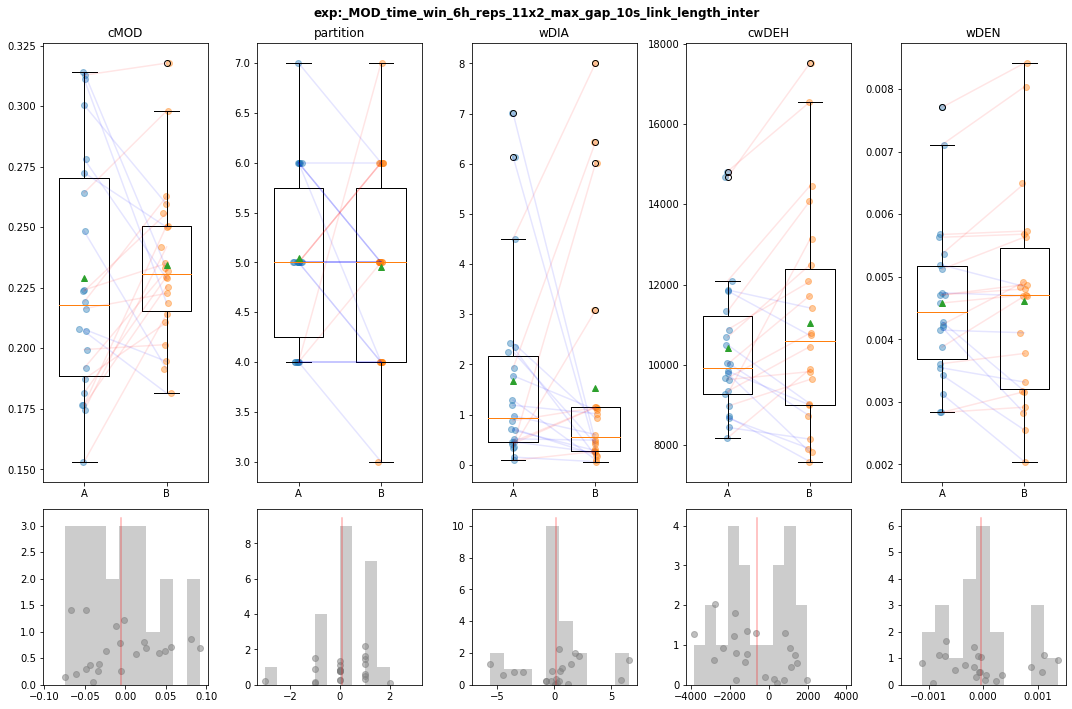

In [11]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
pv_dict
prop_list = list(pv_dict.keys())

# Save p values on the summary dataframerm(list=ls())

pv_dict['exp'] = exp
pv_dict['time_win (h)'] = time_win
pv_dict['link_type'] = link_type
pv_dict['pv/effect'] = 'pv'
pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

# Raw data specific property
fig, axs = plt.subplots(2, len(prop_list), 
                        gridspec_kw={'height_ratios': [2.5, 1]},
                        figsize=(15,10))

effect_dict = {}
for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab['A-B'] = df_ab.A-df_ab.B


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(['A', 'B']):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

    # box plot
    box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6)
    
    # scatter plot
    for x, val in zip(xs, vals):
        axs[0, idx_p].scatter(x, val, alpha=0.4)
    
    # step_line plot
    for idx_step_line in range(len(df_ab)):
        axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                           color = 'r' if df_ab['A-B'].iloc[idx_step_line]<0 else 'b')

    means = df_ab.mean()
    stds =  df_ab.std()
    axs[0, idx_p].set_title(p)
    
    # statistical annotation
    
    if pv_dict[p]<=0.05:
        stat_sign = '*' + int(pv_dict[p]<=0.01)*'*' + int(pv_dict[p]<=0.001)*'*' + int(pv_dict[p]<=0.0001)*'*'
        x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        mm =np.max(df_ab.max())
        y, h, col = 1.01*mm, 0.005*mm, 'k'
        axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)
    
    # save effect 
    effect_dict[p] = df_ab['A-B'].mean() / df_ab['A-B'].std()
    
    # Histogram of difference
    axs[1, idx_p].hist(df_ab['A-B'],alpha=0.4, color = 'gray')
    axs[1, idx_p].scatter(df_ab['A-B'], abs(np.random.normal(0, 1, df_ab['A-B'].values.shape[0])), color = 'gray', alpha = 0.5)
    axs[1, idx_p].set_xlim([-1.1*np.max(abs(df_ab['A-B'])), 1.1*np.max(abs(df_ab['A-B']))])
    axs[1, idx_p].plot([df_ab['A-B'].mean(), df_ab['A-B'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
    plt.tight_layout()

    
# Save effects on the summary dataframe
effect_dict['exp'] = exp
effect_dict['time_win (h)'] = time_win
effect_dict['link_type'] = link_type
effect_dict['pv/effect'] = 'effect'
pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)



title = 'exp:_' + exp + '_time_win_' + str(time_win) + 'h' + '_reps_' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) +  '_max_gap_' + str(max_gap) + 's_link_' + link_type
fig = plt.suptitle(title, fontweight="bold")
plt.tight_layout()
plt.savefig('plots/' + title + '.png', facecolor='white', transparent=False)
plt.show()

In [20]:

# Export dataframe for stats
pv_effect_df.to_csv('data/pv_effect_df.csv')

pv_effect_df


,exp,time_win (h),link_type,pv/effect,cMOD,partition,wDIA,cwDEH,wDEN
0,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096
1,MOD,6,length_inter,effect,-0.109299,0.085362,0.053896,-0.381609,-0.05032
2,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096
3,MOD,6,length_inter,effect,-0.109299,0.085362,0.053896,-0.381609,-0.05032
4,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096
5,MOD,6,length_inter,effect,-0.109299,0.085362,0.053896,-0.381609,-0.05032
6,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096
7,MOD,6,length_inter,effect,-0.109299,0.085362,0.053896,-0.381609,-0.05032
8,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096
9,MOD,6,length_inter,effect,-0.109299,0.085362,0.053896,-0.381609,-0.05032


## Plotting
### (Connectivity)

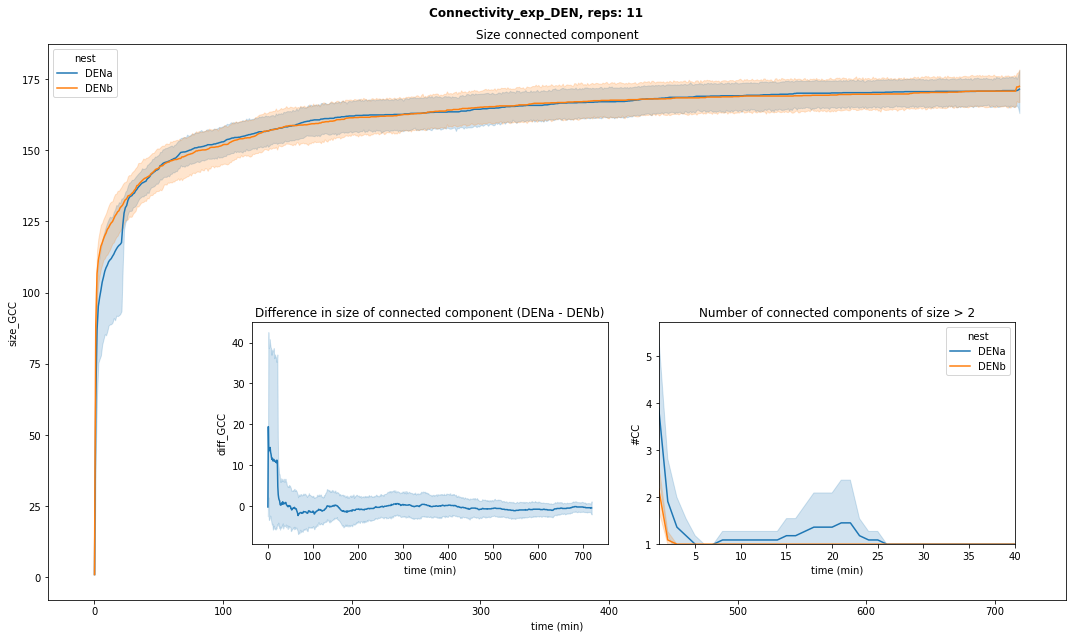

In [329]:
exp = 'DIA'# Reading dataframe of connectivity
Gcc_df = pd.read_pickle('data/Gcc_NEST.pkl')

#Filter for the experiement of interest
Gcc_df = Gcc_df[Gcc_df.rep != 20]
Gcc_df = Gcc_df[[e[0:3] == exp for e in Gcc_df.exp]]
Gcc_df.sort_values(['rep','exp'])
connect_df = pd.DataFrame(columns=['rep', 'nest', 'time (min)', 'size_GCC', '#CC'])

# treshold minimal partition size
tresh_part = 2

# Reformatting dataframe
for row in range(len(Gcc_df)):
    df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                          'nest': [Gcc_df.exp.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                          'time (min)': Gcc_df.Gcc.iloc[row][1],
                          'size_GCC': [len(cc[0]) for cc in Gcc_df.Gcc.iloc[row][0]],
                          '#CC': [sum([len(p) > tresh_part for p in cc]) for cc in Gcc_df.Gcc.iloc[row][0]]})
    connect_df = pd.concat([connect_df, df_aux], ignore_index=True)
    
# Plotting    
fig, axs = plt.subplots(1, 1)
title = 'Connectivity_exp_' + exp + ', reps: ' + str(int(len(Gcc_df)/2)) 
supt = plt.suptitle(title, fontweight="bold")
# Plot 1 (size GCC)
sns.lineplot(data=connect_df, x="time (min)", y="size_GCC", hue="nest", ax=axs)
axs.set_title('Size connected component')
plt.tight_layout()
axs_i_r = axs.inset_axes([0.6,0.1,0.35,0.4])

# Plot 1 (number CC)
sns.lineplot(data=connect_df, x="time (min)", y="#CC", hue="nest", ax=axs_i_r)
axs_i_r.set_title('Number of connected components of size > ' + str(tresh_part))
axs_i_r.set_xlim([1,40])
axs_i_r.set_ylim(bottom=1)
plt.tight_layout()

# ====================================
# Difference in size of GCC
diff_connect_df = pd.DataFrame(columns=['rep', 'time (min)', 'diff_GCC'])

def diff_list_GCC(A, B):
    A_len = [len(a) for a in A]
    B_len = [len(b) for b in B]
    return [A_len[i] - B_len[i] for i in range(min(len(A), len(B)))]
    
# Reformatting dataframe
for row in range(0, len(Gcc_df) -1, 2):
    diff_GCC = diff_list_GCC(Gcc_df.Gcc.iloc[row][0], Gcc_df.Gcc.iloc[row + 1][0])
    df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(diff_GCC),
                          'time (min)': range(len(diff_GCC)),
                          'diff_GCC': diff_GCC})
    diff_connect_df = pd.concat([diff_connect_df, df_aux], ignore_index=True)

# Plotting    
# Plot 3 (diff size GCC)
axs_i_l = axs.inset_axes([0.2,0.1,0.35,0.4])
sns.lineplot(data=diff_connect_df, x="time (min)", y="diff_GCC", ax=axs_i_l)
axs_i_l.set_title('Difference in size of connected component (' + Gcc_df.exp.iloc[0] + ' - ' + Gcc_df.exp.iloc[1] + ')')
plt.tight_layout()

#Savefig
plt.savefig('plots/' + title + '.png', facecolor='white', transparent=False)



## Plotting
### (Relative difference)

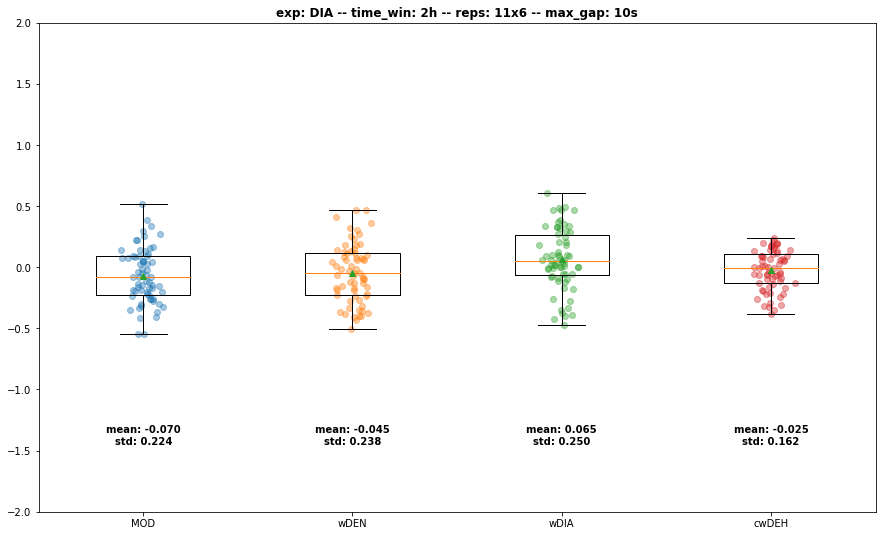

In [231]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'cwDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")

## p-values & effect visualisation

In [74]:
pv_effect_df = df = pd.read_csv('data/pv_effect_df.csv', index_col=0)


for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
    
    for link_type in ['length_inter', '#inter']:
        pv_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                             (pv_effect_df['pv/effect'] == 'pv') & 
                             (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        effect_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                                 (pv_effect_df['pv/effect'] == 'effect') & 
                                 (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        #effect_df[pv_df>0.05] = np.nan

        # Annotation
        sns.set(font_scale = 1.3)
        annot = pv_df.copy()

        for i in range(np.shape(annot)[0]):
            for j in range(np.shape(annot)[1]):
                annot.iloc[i,j] = '(p= {:.4f})\n {:f}'.format(annot.iloc[i,j], effect_df.iloc[i,j])

        annot[pv_df>0.05] = ''
        plt.figure()
        ax = sns.heatmap(effect_df, linewidths=1,
                             linecolor='black',
                             cmap='vlag',
                             center=0,
                             vmin=-0.4,
                             annot_kws={"style": "italic", "weight": "bold"},
                             vmax=0.4,
                             annot = annot, fmt = '',
                             cbar_kws={'label': 'effect'})
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        title = 'stats_summary_exp_' + exp + '_link type_' + link_type
        fig = plt.suptitle(title, fontweight="bold")
        plt.savefig('plots/' + title + '_.png', facecolor='white', transparent=False)
        plt.close()

